In [2]:
import torch
from torchsummary import summary
from CNN import CNN
from FC import FC
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# mnist dataset
dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn = CNN().to(DEVICE)
summary(cnn, (1, 28, 28))
cnn.weight_init()

train_size = int(0.6 * len(dataset))
val_size = len(dataset) - train_size

training_set, validation_set = random_split(dataset, [train_size, val_size])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              ReLU-2            [-1, 4, 28, 28]               0
         MaxPool2d-3            [-1, 4, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]             296
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
              ReLU-8             [-1, 16, 7, 7]               0
         MaxPool2d-9             [-1, 16, 3, 3]               0
          Flatten-10                  [-1, 144]               0
           Linear-11                   [-1, 10]           1,450
          Softmax-12                   [-1, 10]               0
Total params: 2,954
Trainable params: 2,954
Non-trainable params: 0
-----------------------------------

In [3]:
epochs = 10
batch_size = 32

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4)


optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [4]:
cnn_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

for epoch in range(epochs):
    cum_loss = 0
    print(f"Epoch {epoch + 1}\n-------------------------------")
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # Backward and optimize
        optimizer.zero_grad()
        # Forward pass
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        cum_loss += loss.item()
        # Backward and optimize
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Loss: {cum_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    cnn_df = pd.concat([cnn_df, pd.DataFrame([[epoch + 1, cum_loss / len(train_loader), 100 * correct / total]],
                                             columns=['epoch', 'loss', 'accuracy'])])
cnn_df.to_csv('cnn.csv', index=False)
torch.save(cnn.state_dict(), 'cnn.pth')

Epoch 1
-------------------------------
Loss: 1.6619, Accuracy: 94.51%
Epoch 2
-------------------------------
Loss: 1.5113, Accuracy: 95.95%
Epoch 3
-------------------------------
Loss: 1.5016, Accuracy: 96.54%
Epoch 4
-------------------------------
Loss: 1.4972, Accuracy: 96.75%
Epoch 5
-------------------------------
Loss: 1.4927, Accuracy: 96.91%
Epoch 6
-------------------------------
Loss: 1.4900, Accuracy: 96.51%
Epoch 7
-------------------------------
Loss: 1.4876, Accuracy: 97.28%
Epoch 8
-------------------------------
Loss: 1.4850, Accuracy: 97.17%
Epoch 9
-------------------------------
Loss: 1.4841, Accuracy: 97.64%
Epoch 10
-------------------------------
Loss: 1.4835, Accuracy: 97.47%


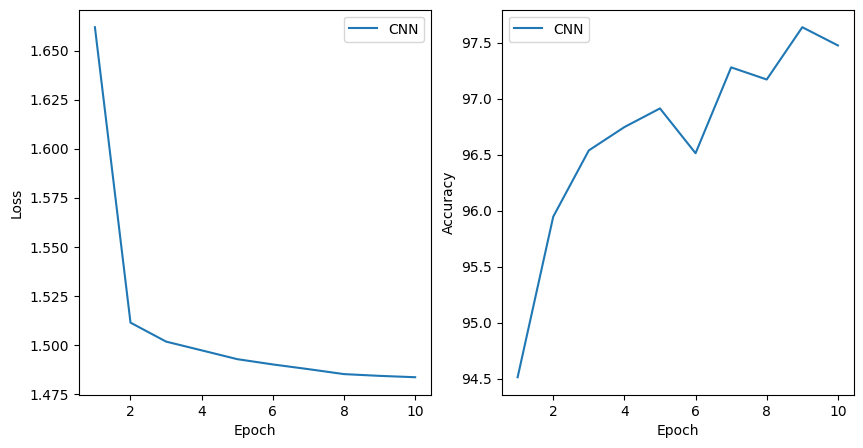

In [5]:
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_df['epoch'], cnn_df['loss'], label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(cnn_df['epoch'], cnn_df['accuracy'], label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fc = FC().to(DEVICE)
summary(fc, (1, 28, 28))
fc.weight_init()

train_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size

training_set, validation_set = random_split(dataset, [train_size, val_size])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          25,120
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 10]             330
           Softmax-4                   [-1, 10]               0
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [7]:
epochs = 10
batch_size = 32

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4)


optimizer = torch.optim.Adam(fc.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
fc_df = pd.DataFrame(columns=['epoch', 'loss', 'accuracy'])

for epoch in range(epochs):
    cum_loss = 0
    print(f"Epoch {epoch + 1}\n-------------------------------")
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # Backward and optimize
        optimizer.zero_grad()
        # Forward pass
        outputs = fc(images)
        loss = criterion(outputs, labels)
        cum_loss += loss.item()
        # Backward and optimize
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = fc(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Loss: {cum_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    fc_df = pd.concat([fc_df, pd.DataFrame([[epoch + 1, cum_loss / len(train_loader), 100 * correct / total]],
                                             columns=['epoch', 'loss', 'accuracy'])])
fc_df.to_csv('fc.csv', index=False)
torch.save(fc.state_dict(), 'fc.pth')

Epoch 1
-------------------------------
Loss: 1.7088, Accuracy: 89.70%
Epoch 2
-------------------------------
Loss: 1.5667, Accuracy: 90.92%
Epoch 3
-------------------------------
Loss: 1.5479, Accuracy: 91.63%
Epoch 4
-------------------------------
Loss: 1.5362, Accuracy: 91.99%
Epoch 5
-------------------------------
Loss: 1.5289, Accuracy: 92.45%
Epoch 6
-------------------------------
Loss: 1.5217, Accuracy: 92.75%
Epoch 7
-------------------------------
Loss: 1.5166, Accuracy: 92.72%
Epoch 8
-------------------------------
Loss: 1.5123, Accuracy: 93.28%
Epoch 9
-------------------------------
Loss: 1.5081, Accuracy: 93.36%
Epoch 10
-------------------------------
Loss: 1.5055, Accuracy: 92.92%


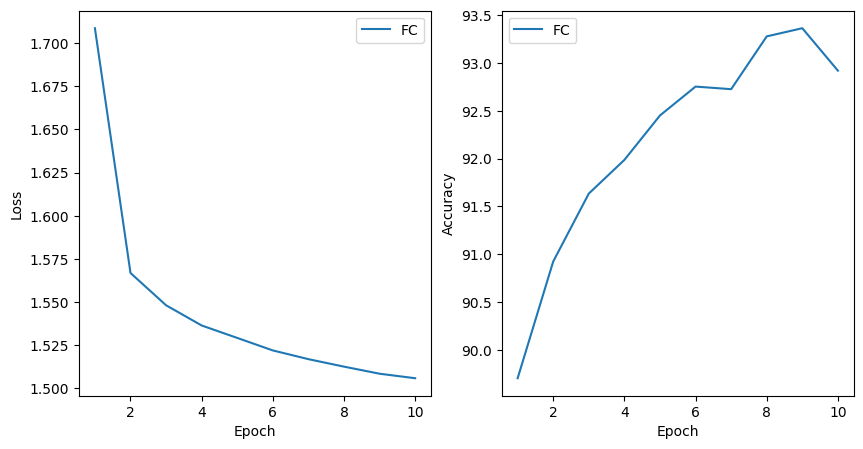

In [9]:
# plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fc_df['epoch'], fc_df['loss'], label='FC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(fc_df['epoch'], fc_df['accuracy'], label='FC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

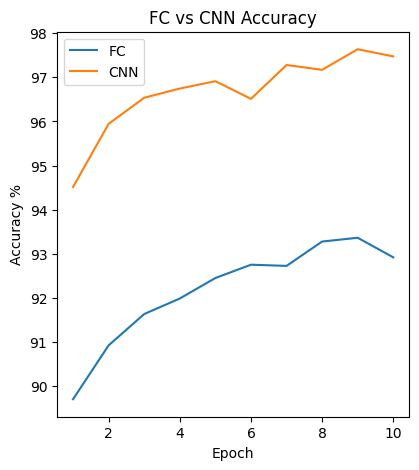

In [10]:
# plot fcc and cnn accuracy
fc_df = pd.read_csv('fc.csv')
cnn_df = pd.read_csv('cnn.csv')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fc_df['epoch'], fc_df['accuracy'], label='FC')
plt.plot(cnn_df['epoch'], cnn_df['accuracy'], label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()
plt.title('FC vs CNN Accuracy')

plt.savefig('fc_vs_cnn_accuracy.png')

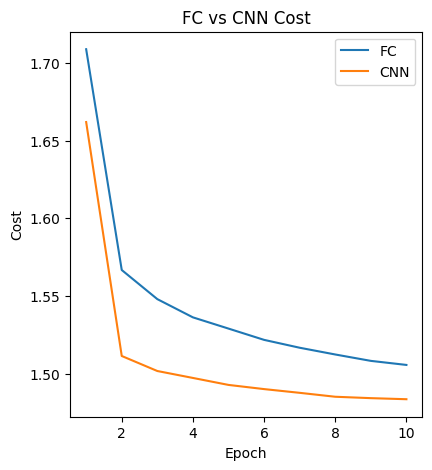

In [11]:
# plot fcc and cnn accuracy
fc_df = pd.read_csv('fc.csv')
cnn_df = pd.read_csv('cnn.csv')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fc_df['epoch'], fc_df['loss'], label='FC')
plt.plot(cnn_df['epoch'], cnn_df['loss'], label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.title('FC vs CNN Cost')

plt.savefig('fc_vs_cnn_cost.png')

[]

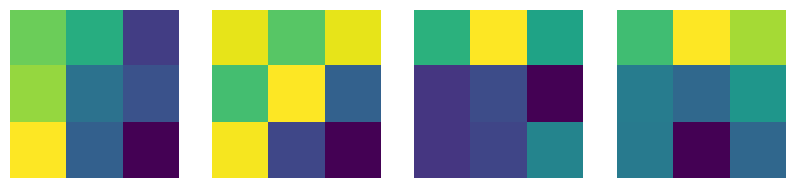

In [4]:
# Take a look after the first conv layer
cnn = CNN().to(DEVICE)
cnn.load_state_dict(torch.load('cnn.pth'))

# Show all 4 filters of the first conv layer
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(cnn.conv1.weight.data[i].cpu().numpy()[0])
    plt.axis('off')
plt.plot()

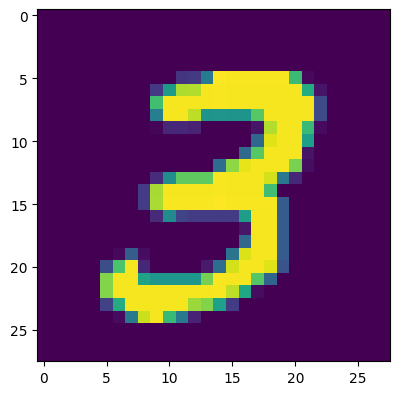

In [6]:
image = dataset[7][0].unsqueeze(0).to(DEVICE)

# Show the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.cpu().numpy()[0][0])

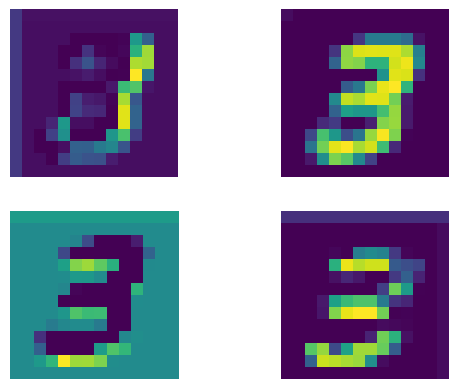

In [7]:
for j in range(4):
    plt.subplot(2, 2, j + 1)
    pred = cnn.pool(cnn.relu(cnn.conv1(image.to(DEVICE))))
    plt.imshow(pred[0][j].cpu().detach().numpy())

    plt.axis('off')

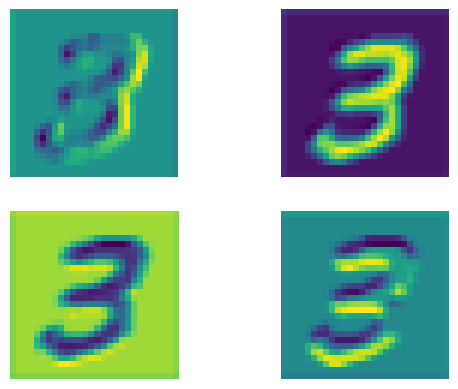

In [14]:
for j in range(4):
    plt.subplot(2, 2, j + 1)
    pred = (cnn.conv1(image.to(DEVICE)))
    plt.imshow(pred[0][j].cpu().detach().numpy())

    plt.axis('off')

[]

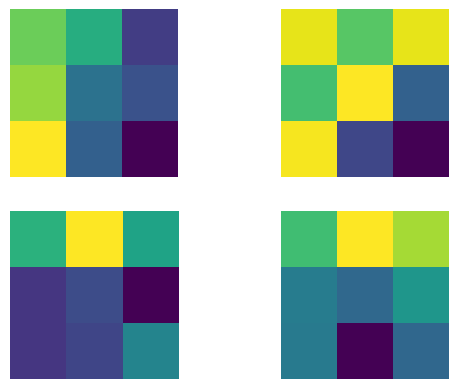

In [56]:
for j in range(4):
    plt.subplot(2, 2, j + 1)
    plt.imshow(cnn.conv1.weight.data[j].cpu().numpy()[0])
    plt.axis('off')
plt.plot()

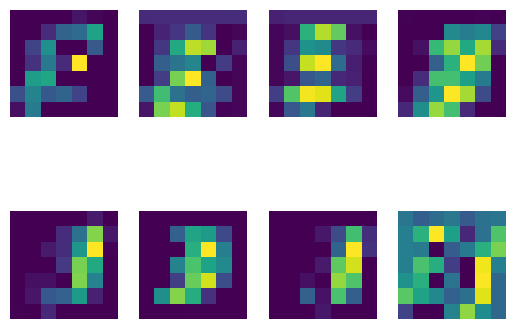

In [9]:
for j in range(8):
    plt.subplot(2, 4, j + 1)
    pred = cnn.pool(cnn.relu(cnn.conv1(image.to(DEVICE))))
    pred2 = cnn.pool(cnn.relu(cnn.conv2(pred)))
    plt.imshow(pred2[0][j].cpu().detach().numpy())

    plt.axis('off')

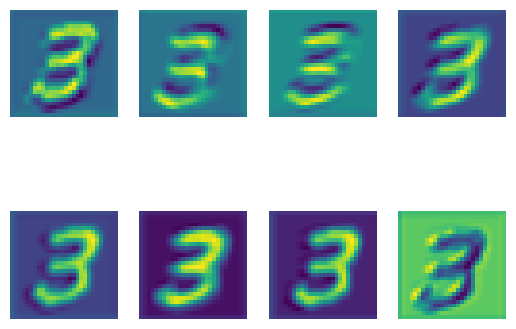

In [15]:
for j in range(8):
    plt.subplot(2, 4, j + 1)
    pred = cnn.conv1(image.to(DEVICE))
    pred2 = cnn.conv2(pred)
    plt.imshow(pred2[0][j].cpu().detach().numpy())

    plt.axis('off')

[]

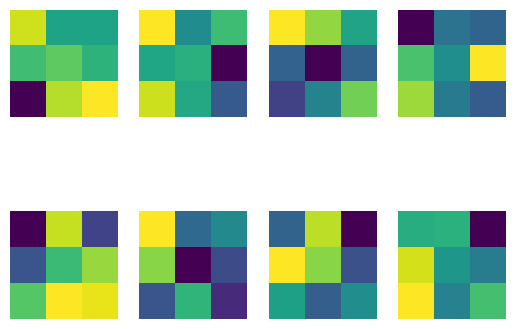

In [16]:
for j in range(8):
    plt.subplot(2, 4, j + 1)
    plt.imshow(cnn.conv2.weight.data[j].cpu().numpy()[0])
    plt.axis('off')
plt.plot()

[]

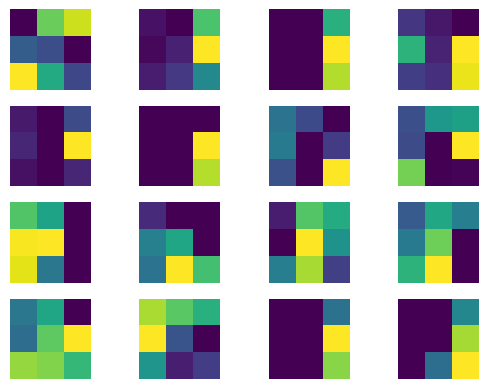

In [12]:
for j in range(16):
    plt.subplot(4, 4, j + 1)
    pred = cnn.pool(cnn.relu(cnn.conv1(image.to(DEVICE))))
    pred2 = cnn.pool(cnn.relu(cnn.conv2(pred)))
    pred3 = cnn.pool(cnn.relu(cnn.conv3(pred2)))
    plt.imshow(pred3[0][j].cpu().detach().numpy())

    plt.axis('off')

plt.plot()

[]

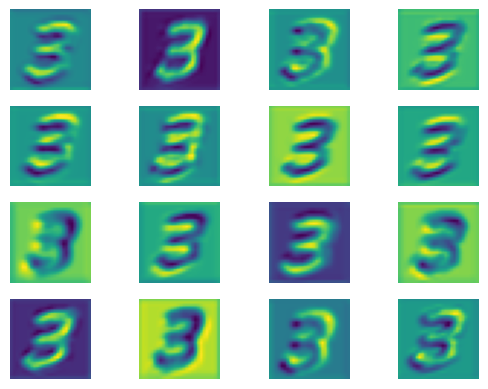

In [17]:
for j in range(16):
    plt.subplot(4, 4, j + 1)
    pred =  cnn.conv1(image.to(DEVICE))
    pred2 = cnn.conv2(pred)
    pred3 = cnn.conv3(pred2)
    plt.imshow(pred3[0][j].cpu().detach().numpy())

    plt.axis('off')

plt.plot()

[]

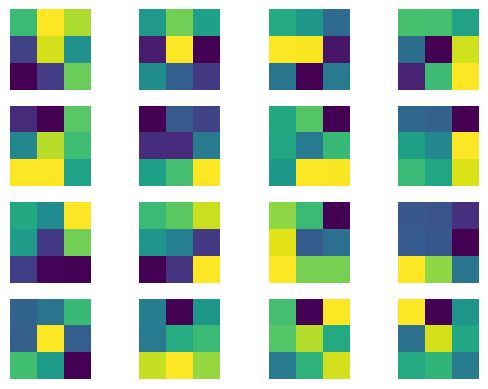

In [13]:
for j in range(16):
    # plot kernel with value in each grid
    plt.subplot(4, 4, j + 1)
    plt.imshow(cnn.conv3.weight.data[j].cpu().numpy()[0])
    plt.axis('off')
plt.plot()